DistArray Example: Seismic Volume
---------------------------------
To illustrate some of the things that we can do with DistArray, we provide an example with a simulated 3D seismic volume.

Start a cluster
---------------
This example requires an `IPython.parallel` cluster to be running.
Outside the notebook, run
```
dacluster start -n4
```

Preliminaries
-------------
We will start off by importing some things that we will use, and also enable inline matplotlib plotting.

In [1]:
from __future__ import print_function

%matplotlib inline

from six.moves import range

from distarray.globalapi import Context, Distribution
from distarray.globalapi.distarray import DistArray

from numpy import linspace, float32
from matplotlib import pyplot

Create a volume
---------------
First we create a DistArray of the desired size for the seismic volume.  To start, we fill it with zeros.

We need to specify a Context, the array size, and the distribution of the array across the available processes.  We will use the block distribution for the x and y axes (which will partition these axes across the engines) and *not* distribute the z axis (so each trace, or z slice, will be on a single process).

In [2]:
def create_empty_volume(context, dist, shape):
    """Create an empty seismic volume."""
    if len(shape) != 3:
        raise ValueError('Volume shape must be 3D.')
    print('Creating volume array %d x %d x %d...' % (
        shape[0], shape[1], shape[2]))
    distribution = Distribution(context, shape, dist=dist)
    da = context.zeros(distribution, dtype=float32)
    return da

# Create a DistArray context.
context = Context()

# Dimensions of volume array.
VOLUME_SHAPE = (256, 256, 1024)

# Physical size of volume.
VOLUME_SIZE = (10.0, 10.0, 20.0)

# Array distribution for volume.
VOLUME_DISTRIBUTION = ('b', 'b', 'n')

seismic_volume = create_empty_volume(context, VOLUME_DISTRIBUTION, VOLUME_SHAPE)
print(seismic_volume)

Creating volume array 256 x 256 x 1024...
<DistArray(shape=(256, 256, 1024), targets=[0, 1, 2, 3])>


We also need to know the physical positions of each array element, so lets calculate those as well.

In [3]:
physical_x = linspace(0.0, VOLUME_SIZE[0], VOLUME_SHAPE[0])
physical_y = linspace(0.0, VOLUME_SIZE[1], VOLUME_SHAPE[1])
physical_z = linspace(0.0, VOLUME_SIZE[2], VOLUME_SHAPE[2])

Creating horizons
-----------------
Now we fill the volume with some interesting data to process.  To make this similar to a real seismic volume, we construct this in terms of 'horizons', which are 2D surfaces inside the volume.  The data values in the volume will change as we pass down through the horizons.  To make it simple, we use plane surfaces as the horizons here.  We also attach some parameters to the horizons which control how the seismic data changes as we pass through the horizons.  Our horizons will use the x and y dimensions and distribution of the full 3D array.

To properly calculate the depth at each point, we need the physical x and y coordinates of the array element.  These are passed into the outer function, and for each local calculation, we extract the values corresponding to each local array.

In [4]:
def local_create_horizon(horizon_la, physical_x, physical_y, normal, D):
    """Get the horizon surface, which is a plane."""

    def plane(x, y, normal, D):
        """Get the depth on the plane at the x and y coordinates."""
        from math import sqrt
        nx, ny, nz = normal
        nmag = sqrt(nx * nx + ny * ny + nz * nz)
        nx, ny, nz = nx / nmag, ny / nmag, nz / nmag
        z0 = (D - nx * x - ny * y) / nz
        return z0

    def create_horizon(horizon, physical_xy, normal, D):
        """Create the horizon plane."""
        shape = horizon.shape
        if len(shape) != 2:
            raise ValueError('Horizon shape must be 2D.')
        for i in range(shape[0]):
            for j in range(shape[1]):
                x = physical_xy[i, j, 0]
                y = physical_xy[i, j, 1]
                horizon[i, j] = plane(x, y, normal, D)

    from distarray.localapi import LocalArray
    horizon = horizon_la.ndarray
    shape = horizon.shape
    # Get physical x and y values in an array the same shape as the horizon.
    physical_xy = numpy.empty((shape[0], shape[1], 2))
    for i in range(shape[0]):
        for j in range(shape[1]):
            gi, gj = horizon_la.global_from_local((i, j))
            physical_xy[i, j, 0] = physical_x[gi]
            physical_xy[i, j, 1] = physical_y[gj]
    create_horizon(horizon, physical_xy, normal, D)
    res = LocalArray(horizon_la.distribution, buf=horizon)
    rtn = proxyize(res)
    return rtn

def create_distarray_horizon(context, shape, physical_x, physical_y, normal, D):
    """Create a horizon as a 2D DistArray."""
    horizon_dist = (VOLUME_DISTRIBUTION[0], VOLUME_DISTRIBUTION[1])
    distribution = Distribution(context, shape, dist=horizon_dist)
    horizon = DistArray(distribution, dtype=float32)
    context.apply(local_create_horizon,
                  (horizon.key, physical_x, physical_y, normal, D))
    return horizon

def create_horizons(volume, physical_x, physical_y):
    """Create some horizons appropriate for the seismic volume.

    We describe the plane surface with a normal and a constant,
    and also provide some parameters to use later.
    """
    context = volume.context
    shape = (volume.shape[0], volume.shape[1])
    normal_1, D_1, params_1 = (
        (0.1, -0.2, 1.0), 10.0, (100.0, 40.0, 1.25, 0.1))
    normal_2, D_2, params_2 = (
        (0.4, 0.1, 1.0), 15.0, (25.0, 15.0, 1.25, 0.7))
    horizon_1 = create_distarray_horizon(context, shape,
                                         physical_x, physical_y,
                                         normal_1, D_1)
    horizon_2 = create_distarray_horizon(context, shape,
                                         physical_x, physical_y,
                                         normal_2, D_2)
    rtn = [(horizon_1, params_1), (horizon_2, params_2)]
    return rtn

# Now create the horizons.
print('Creating horizons...')
horizons = create_horizons(seismic_volume, physical_x, physical_y)
print(horizons)

Creating horizons...
[(<DistArray(shape=(256, 256), targets=[0, 1, 2, 3])>, (100.0, 40.0, 1.25, 0.1)), (<DistArray(shape=(256, 256), targets=[0, 1, 2, 3])>, (25.0, 15.0, 1.25, 0.7))]


Filling the array
-----------------
Now we need to use these horizons to fill the seismic volume with data.  For each trace, which is a column in the array with constant x and y, we add values to the volume, based on how far the depth of the array element is from the horizon surface.  For this example, we add a Gaussian peak at the horizon depth and also use a hyperbolic tangent to act as a smooth step-like function, which will change values as we pass through the horizon.  We use the extra parameters we calculated earlier for each horizon to control the specific numerical values.

In [5]:
def local_add_horizon(volume_la, horizon_la, z, horizon_params):
    """Update the volume to change as one passes through the horizon."""

    def horizon_function(z, z0, A=100.0, B=40.0, C=2.5, mu=0.1):
        """A hopefully interesting looking function of depth z.

        Gaussian, with a step-like function past the gaussian peak.
        The peak is at depth z=z0.
        """
        from numpy import exp, tanh
        u = mu * (z - z0) ** 2
        v = mu * (z - z0)
        # Combine Gaussian, hyperbolic tangent, and constant.
        # The hyperbolic tangent serves as a smooth step.
        r = A * exp(-u) + B * tanh(v) + C
        return r

    def add_horizon(vol, hor, z, horizon_params):
        """Add the effect of a horizon to the seismic volume data."""
        shape = hor.shape
        A, B, C, mu = horizon_params
        for i in range(shape[0]):
            for j in range(shape[1]):
                z0 = hor[i, j]
                vol[i, j, :] += horizon_function(z, z0, A=A, B=B, C=C, mu=mu)
        return vol

    vol = volume_la.ndarray
    hor = horizon_la.ndarray
    add_horizon(vol, hor, z, horizon_params)
    return volume_la

Add some randomness
-------------------
Finally, we add some random noise to the data.

In [6]:
def local_add_random(volume_la):
    """Add randomness to the local array."""

    def add_random(vol, R):
        shape = vol.shape
        rnd = numpy.random.randn(*shape)
        vol[:, :, :] += R * rnd

    vol = volume_la.ndarray
    add_random(vol, R=2.0)
    return volume_la

Now we put all this together and fill our seismic volume with data.

In [7]:
def fill_volume(volume, horizons):
    """Fill the seismic volume with some interesting structure."""
    context = volume.context
    shape = volume.shape
    if len(shape) != 3:
        raise ValueError('Volume shape must be 3D.')
    # Add data for each horizon...
    for ih, horizon_data in enumerate(horizons):
        print('Applying horizon %d...' % (ih + 1))
        horizon, horizon_params = horizon_data
        context.apply(local_add_horizon,
                      (volume.key, horizon.key, physical_z, horizon_params))
    # Add global randomness.
    print('Adding randomness...')
    context.apply(local_add_random, (volume.key,))
    print('Done.')
    
fill_volume(seismic_volume, horizons)
print(seismic_volume)

Applying horizon 1...
Applying horizon 2...
Adding randomness...
Done.
<DistArray(shape=(256, 256, 1024), targets=[0, 1, 2, 3])>


Plotting arrays
---------------
We want to do something interesting with our seismic volume, so let's start by making plots of 2D sections.  We can't pass DistArrays directly to matplotlib, so we will convert them to normal NumPy arrays for this.

In [8]:
def plot_ndarray(ndarray, title, x_label, y_label):
    """Plot a 2D numpy array."""
    num_dim = len(ndarray.shape)
    if (num_dim != 2):
        raise ValueError('Array must be 2D for plotting.')
    cmap = 'RdBu'
    pyplot.matshow(ndarray, cmap=cmap)
    pyplot.title(title)
    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)
    pyplot.colorbar()
    pyplot.show()
    
def plot_distarray(distarray, title, x_label, y_label, transpose=True):
    """Plot a 2D DistArray."""
    # Convert to ndarray for plotting.
    ndarray = distarray.toarray()
    # Transpose to make depth look like depth.
    if transpose:
        ndarray = ndarray.transpose()
    plot_ndarray(ndarray, title, x_label, y_label)    

Slicing
-------
Now let's take some slices of our seismic volume.  These are 2D sections so that we can plot them.  Notice that we are slicing DistArrays directly.  This works just like slicing NumPy arrays except that we get a DistArray back. We will pick an arbitrary slice of the volume on each axis to plot.

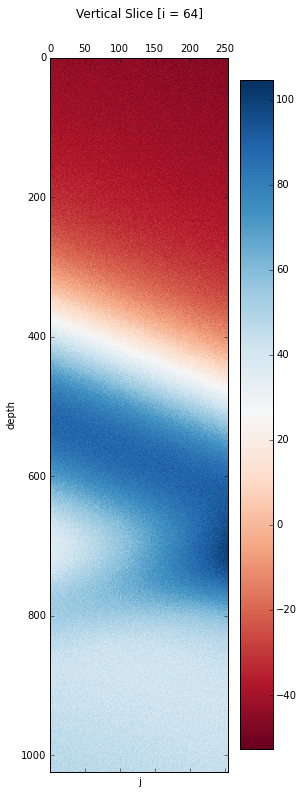

In [9]:
i_index = seismic_volume.shape[0] // 4
i_slice = seismic_volume[i_index, :, :]
title = 'Vertical Slice [i = %d]' % (i_index)
plot_distarray(i_slice, title, 'j', 'depth')

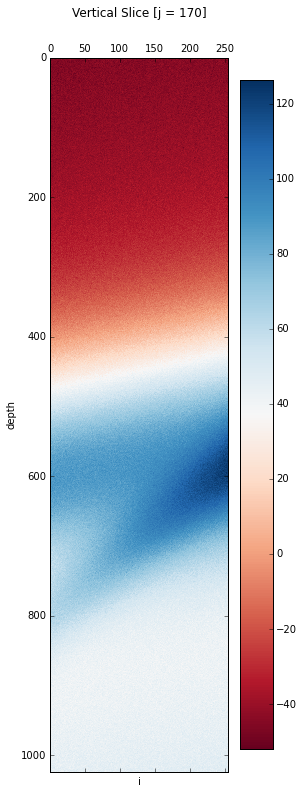

In [10]:
j_index = (2 * seismic_volume.shape[1]) // 3
j_slice = seismic_volume[:, j_index, :]
title = 'Vertical Slice [j = %d]' % (j_index)
plot_distarray(j_slice, title, 'i', 'depth')

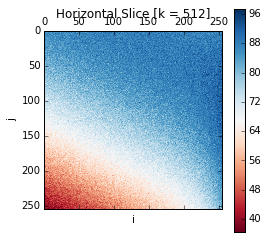

In [11]:
k_index = seismic_volume.shape[2] // 2
k_slice = seismic_volume[:, :, k_index]
title = 'Horizontal Slice [k = %d]' % (k_index)
plot_distarray(k_slice, title, 'i', 'j')

Statistics
----------
We can calculate statistics on the volume in the same way that we do with NumPy arrays.  Let's calculate several different statistics and make a plot of some of them.  We calculate the statistics for each trace, and the result is a 2D distarray.

In [12]:
trace_min = seismic_volume.min(axis=2)
trace_max = seismic_volume.max(axis=2)
trace_mean = seismic_volume.mean(axis=2)
trace_var = seismic_volume.var(axis=2)
trace_std = seismic_volume.std(axis=2)

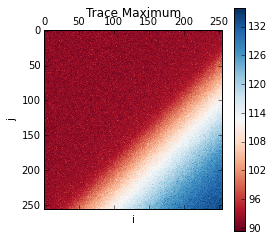

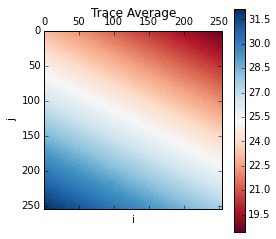

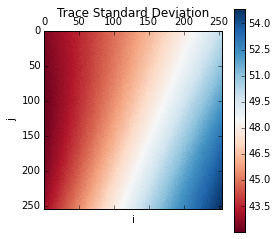

In [13]:
plot_distarray(trace_max, 'Trace Maximum', 'i', 'j', False)
plot_distarray(trace_mean, 'Trace Average', 'i', 'j', False)
plot_distarray(trace_std, 'Trace Standard Deviation', 'i', 'j', False)

Filtering arrays
----------------
As another example of an operation on DistArrays, let's apply a 3-point averaging filter along each trace.

In [14]:
def local_filter_avg3(la):
    """Filter a local array via 3-point average over z axis."""

    def filter_avg3(a):
        """Filter a local array via 3-point average over z axis.
        
        A 2-point average is used at the ends.
        """
        from numpy import empty_like
        b = empty_like(a)
        b[:, :, 0] = (a[:, :, 0] + a[:, :, 1]) / 2.0
        b[:, :, 1:-1] = (a[:, :, :-2] + a[:, :, 1:-1] + a[:, :, 2:]) / 3.0
        b[:, :, -1] = (a[:, :, -2] + a[:, :, -1]) / 2.0
        return b

    from distarray.localapi import LocalArray
    a = la.ndarray
    b = filter_avg3(a)
    res = LocalArray(la.distribution, buf=b)
    rtn = proxyize(res)
    return rtn

In [15]:
context = seismic_volume.context
filtered_key = context.apply(local_filter_avg3, (seismic_volume.key,))
filtered_volume = DistArray.from_localarrays(filtered_key[0], context=context)
print(filtered_volume)

<DistArray(shape=(256, 256, 1024), targets=[0, 1, 2, 3])>


To take a look at our 3D filtered array, let's take a slice and plot it.

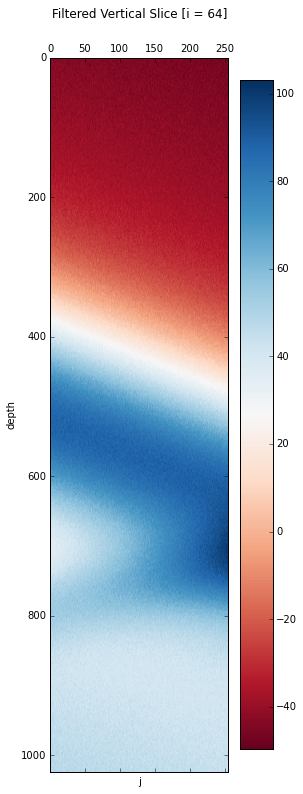

In [16]:
i_index = filtered_volume.shape[0] // 4
i_slice = filtered_volume[i_index, :, :]
title = 'Filtered Vertical Slice [i = %d]' % (i_index)
plot_distarray(i_slice, title, 'j', 'depth')

Conclusion
----------
We have demonstrated a number of features of DistArray here, on a somewhat realistic example.  Hopefully this gives you a flavor of how to use this package!